In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 14.0 MB/s eta 0:00:00


In [ ]:
# --- PESV v3 "Championship" with Hyperparameter Tuning (Hierarchical Flow) ---
#
# Workflow:
# 1. Binary Classification (VPN vs Non-VPN) on FULL dataset.
# 2. Filter for VPN traffic only.
# 3. Filter for specific target applications.
# 4. Classify Category and Application within the VPN subset.

print("--- Initializing HFV Hierarchical Classification ---")

import pandas as pd
import numpy as np
import time
import os
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Try importing XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    print("WARNING: XGBoost not installed. Skipping XGBoost.")
    HAS_XGB = False

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- PART 1: Configuration ---

BASE_PATH = "/content/drive/MyDrive/1 Skripsi/skrip16feb"
FINAL_PESV_FILE = os.path.join(BASE_PATH, "HFV_dataset.csv")
SPLIT_MAP_FILE = os.path.join(BASE_PATH, "alpha_train_test_split_map.csv")

# Target Applications for the VPN Step
# UPDATED: Removed 'VPN_' prefix to match dataset labels found in 'application' column.
TARGET_VPN_APPS = [
    'Skype', 'BitTorrent', 'Hangout',
    'Facebook', 'YouTube', 'Email'
]

TEST_SET_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 3
N_ITER_SEARCH = 10

# --- PART 2: Model & Parameter Definitions ---

MODEL_CONFIGS = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
        "params": {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__max_depth": [None, 10, 20, 30],
            "classifier__min_samples_split": [2, 5, 10],
            "classifier__criterion": ["gini", "entropy"]
        }
    }
}

if HAS_XGB:
    MODEL_CONFIGS["XGBoost"] = {
        "model": XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss'),
        "params": {
            "classifier__n_estimators": [100, 200, 300],
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__max_depth": [3, 6, 10],
            "classifier__subsample": [0.8, 1.0]
        }
    }

# --- PART 3: Data Loading Helper ---

def load_data_and_features():
    print(f"\n--- Loading Full Dataset from {FINAL_PESV_FILE} ---")
    if not os.path.exists(FINAL_PESV_FILE):
        print(f"FATAL ERROR: Could not find dataset at '{FINAL_PESV_FILE}'")
        return None, None

    df = pd.read_csv(FINAL_PESV_FILE)

    # Define Feature Columns
    all_cols = set(df.columns)
    alpha_cols = sorted([c for c in all_cols if c.startswith('alpha_pp_')])
    delta_cols = sorted([c for c in all_cols if c.startswith(('c2s_', 's2c_', 'flow_', 'total_'))])
    gamma_cols = sorted([c for c in all_cols if c.startswith('burst_')])

    feature_sets = {
        "Alpha'' (α'') only": alpha_cols,
        "Delta (δ) only": delta_cols,
        "Gamma' (γ') only": gamma_cols,
        "Alpha'' + Delta": alpha_cols + delta_cols,
        "Alpha'' + Gamma'": alpha_cols + gamma_cols,
        "Delta + Gamma'": delta_cols + gamma_cols,
        "Full (α'' + δ + γ')": alpha_cols + delta_cols + gamma_cols,
    }

    return df, feature_sets

# --- PART 4: Tuned Classification Task ---

def run_tuned_classification(df_train, df_test, target_label, feature_set_name, feature_cols, model_name, config):
    print(f" > Training {model_name} on {feature_set_name} ({len(feature_cols)} feats)...")

    X_train = df_train[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y_train = df_train[target_label]
    X_test = df_test[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y_test = df_test[target_label]

    # Encode labels (Union of train/test to handle missing classes in splits)
    le = LabelEncoder()
    all_labels = pd.concat([y_train, y_test], axis=0)
    le.fit(all_labels)
    y_train_encoded = le.transform(y_train)
    y_test_encoded = le.transform(y_test)
    class_names = [str(c) for c in le.classes_]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', config["model"])
    ])

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=config["params"],
        n_iter=N_ITER_SEARCH,
        scoring='f1_macro',
        cv=CV_FOLDS,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )

    start_time = time.time()
    try:
        search.fit(X_train, y_train_encoded)
        best_model = search.best_estimator_
        best_params = search.best_params_
        y_pred = best_model.predict(X_test)

        report = classification_report(y_test_encoded, y_pred, target_names=class_names, output_dict=True)

        return {
            'model': model_name,
            'feature_set': feature_set_name,
            'accuracy': report['accuracy'],
            'f1_weighted': report['weighted avg']['f1-score'],
            'f1_macro': report['macro avg']['f1-score'],
            'time': time.time() - start_time,
            'best_params': str(best_params).replace("classifier__", "")
        }
    except Exception as e:
        print(f"    ERROR in training: {e}")
        return None

# --- PART 5: Main Orchestration ---

def print_results(task_name, metrics_list):
    print(f"\n{'='*100}")
    print(f"--- FINAL RESULTS: {task_name} ---")
    print(f"{'='*100}\n")

    sorted_res = sorted([m for m in metrics_list if m], key=lambda x: x['f1_macro'], reverse=True)

    print(f"{'Model':<15} | {'Feature Set':<22} | {'Acc':<6} | {'F1(W)':<6} | {'F1(Mac)':<8} | {'Time':<5}")
    print("-" * 80)
    for r in sorted_res:
        print(f"{r['model']:<15} | {r['feature_set']:<22} | {r['accuracy']:.4f} | {r['f1_weighted']:.4f} | {r['f1_macro']:.4f}   | {r['time']:<5.1f}")

    print(f"\n--- 🏆 Top 3 Models for {task_name} ---")
    for i, r in enumerate(sorted_res[:3]):
        print(f"{i+1}. {r['model']} [{r['feature_set']}] - Acc: {r['accuracy']:.4f}, Macro F1: {r['f1_macro']:.4f}")
        print(f"   Params: {r['best_params']}")

def main():
    # 1. Load Data
    df, feature_sets = load_data_and_features()
    if df is None: return

    # 2. Merge with Split Map (Global Split)
    if os.path.exists(SPLIT_MAP_FILE):
        print(f"\n--- Loading Split Map: {SPLIT_MAP_FILE} ---")
        split_map = pd.read_csv(SPLIT_MAP_FILE)
        # Normalization (Fix for Case Sensitivity)
        split_map.columns = [c.lower().strip() for c in split_map.columns]

        col_map = {'filename': None, 'split': None}
        for c in split_map.columns:
            if c in ['filename', 'file', 'pcap']: col_map['filename'] = c
            if c in ['split', 'set', 'partition', 'split_group']: col_map['split'] = c

        if not col_map['filename'] or not col_map['split']:
            print("ERROR: Invalid Split Map Columns")
            return

        split_map = split_map.rename(columns={col_map['filename']: 'filename', col_map['split']: 'split'})
        split_map['split'] = split_map['split'].str.lower() # Vital Fix

        df_merged = pd.merge(df, split_map[['filename', 'split']], on='filename', how='inner')
        print(f"Data shape after merge: {df_merged.shape}")
    else:
        print("FATAL ERROR: Split map not found. Aborting to prevent leakage.")
        return

    # ---------------------------------------------------------
    # STEP 1: BINARY CLASSIFICATION (VPN vs NonVPN)
    # ---------------------------------------------------------
    print(f"\n{'#'*40}")
    print(" STEP 1: BINARY CLASSIFICATION (VPN vs NonVPN) ")
    print(f"{'#'*40}")

    df_train = df_merged[df_merged['split'] == 'train']
    df_test = df_merged[df_merged['split'] == 'test']
    print(f"Binary Train Samples: {len(df_train)}, Test Samples: {len(df_test)}")

    binary_metrics = []
    for model_name, config in MODEL_CONFIGS.items():
        for fs_name, fs_cols in feature_sets.items():
            if fs_cols:
                m = run_tuned_classification(df_train, df_test, 'binary_type', fs_name, fs_cols, model_name, config)
                if m: binary_metrics.append(m)

    print_results("Binary Type", binary_metrics)

    # ---------------------------------------------------------
    # STEP 2: VPN-SPECIFIC CLASSIFICATION (Category & App)
    # ---------------------------------------------------------
    print(f"\n{'#'*40}")
    print(" STEP 2: VPN-SPECIFIC CLASSIFICATION ")
    print(f"{'#'*40}")

    # Filter: Keep only VPN rows
    df_vpn = df_merged[df_merged['binary_type'] == 'VPN'].copy()

    # Filter: Keep only Target Apps
    print(f"Filtering for specific apps: {TARGET_VPN_APPS}")
    df_vpn_filtered = df_vpn[df_vpn['application'].isin(TARGET_VPN_APPS)]

    df_train_vpn = df_vpn_filtered[df_vpn_filtered['split'] == 'train']
    df_test_vpn = df_vpn_filtered[df_vpn_filtered['split'] == 'test']

    print(f"VPN Filtered Data - Total: {len(df_vpn_filtered)}")
    print(f"VPN Train Samples: {len(df_train_vpn)}, Test Samples: {len(df_test_vpn)}")

    if len(df_train_vpn) == 0 or len(df_test_vpn) == 0:
        print("WARNING: No samples left after filtering for specific VPN apps. Check dataset labels.")
        return

    # Run Tasks
    for task in ['category', 'application']:
        print(f"\n--- Target: {task} (Within VPN) ---")
        task_metrics = []
        for model_name, config in MODEL_CONFIGS.items():
            for fs_name, fs_cols in feature_sets.items():
                if fs_cols:
                    m = run_tuned_classification(df_train_vpn, df_test_vpn, task, fs_name, fs_cols, model_name, config)
                    if m: task_metrics.append(m)

        print_results(f"VPN {task}", task_metrics)

if __name__ == "__main__":
    main()

--- Initializing HFV Hierarchical Classification ---

--- Loading Full Dataset from /content/drive/MyDrive/1 Skripsi/skrip16feb/HFV_dataset.csv ---

--- Loading Split Map: /content/drive/MyDrive/1 Skripsi/skrip16feb/alpha_train_test_split_map.csv ---
Data shape after merge: (12555, 254)

########################################
 STEP 1: BINARY CLASSIFICATION (VPN vs NonVPN) 
########################################
Binary Train Samples: 10042, Test Samples: 2513
 > Training Random Forest on Alpha'' (α'') only (128 feats)...
 > Training Random Forest on Delta (δ) only (121 feats)...
 > Training Random Forest on Alpha'' + Delta (249 feats)...
 > Training Random Forest on Alpha'' + Gamma' (128 feats)...
 > Training Random Forest on Delta + Gamma' (121 feats)...
 > Training Random Forest on Full (α'' + δ + γ') (249 feats)...
 > Training XGBoost on Alpha'' (α'') only (128 feats)...
 > Training XGBoost on Delta (δ) only (121 feats)...
 > Training XGBoost on Alpha'' + Delta (249 feats)...
 > 

In [ ]:
import pandas as pd
import os

# --- CONFIGURATION ---
# Adjust this path if your files are in a different folder
BASE_PATH = "/content/drive/MyDrive/1 Skripsi/skrip16feb"
DATASET_FILE = "HFV_dataset.csv"
SPLIT_MAP_FILE = "alpha_train_test_split_map.csv"

dataset_path = os.path.join(BASE_PATH, DATASET_FILE)
split_map_path = os.path.join(BASE_PATH, SPLIT_MAP_FILE)

print("=== DIAGNOSTIC REPORT ===")

# 1. INSPECT SPLIT MAP
print(f"\n1. INSPECTING: {SPLIT_MAP_FILE}")
if os.path.exists(split_map_path):
    try:
        df_map = pd.read_csv(split_map_path)
        print(f"   Shape: {df_map.shape}")
        print(f"   Columns: {list(df_map.columns)}")
        print("\n   First 3 rows:")
        print(df_map.head(3))
    except Exception as e:
        print(f"   Error reading file: {e}")
else:
    print(f"   [!] File not found at: {split_map_path}")

# 2. INSPECT MAIN DATASET
print(f"\n2. INSPECTING: {DATASET_FILE}")
if os.path.exists(dataset_path):
    try:
        df_data = pd.read_csv(dataset_path, nrows=5) # Read only first 5 rows for speed
        print(f"   Columns: {list(df_data.columns)}")

        # Check for potential target columns
        potential_targets = ['label', 'binary_type', 'category', 'application', 'label_category', 'label_application']
        found_targets = [c for c in potential_targets if c in df_data.columns]
        print(f"   Found Target Columns: {found_targets}")

        print("\n   First 3 rows:")
        print(df_data.head(3))
    except Exception as e:
        print(f"   Error reading file: {e}")
else:
    print(f"   [!] File not found at: {dataset_path}")

print("\n=== END REPORT ===")

=== DIAGNOSTIC REPORT ===

1. INSPECTING: alpha_train_test_split_map.csv
   Shape: (12736, 2)
   Columns: ['filename', 'split_group']

   First 3 rows:
                                            filename split_group
0  voipbuster3b.pcap.UDP_59-0-45-114_6881_131-202...       TRAIN
1  spotify1.pcap.TCP_54-192-55-68_443_131-202-240...       TRAIN
2  vpn_skype_files1b.pcap.UDP_10-8-8-130_49539_12...       TRAIN

2. INSPECTING: HFV_dataset.csv
   Columns: ['filename', 'application', 'category', 'binary_type', 'alpha_pp_0', 'alpha_pp_1', 'alpha_pp_2', 'alpha_pp_3', 'alpha_pp_4', 'alpha_pp_5', 'alpha_pp_6', 'alpha_pp_7', 'alpha_pp_8', 'alpha_pp_9', 'alpha_pp_10', 'alpha_pp_11', 'alpha_pp_12', 'alpha_pp_13', 'alpha_pp_14', 'alpha_pp_15', 'alpha_pp_16', 'alpha_pp_17', 'alpha_pp_18', 'alpha_pp_19', 'alpha_pp_20', 'alpha_pp_21', 'alpha_pp_22', 'alpha_pp_23', 'alpha_pp_24', 'alpha_pp_25', 'alpha_pp_26', 'alpha_pp_27', 'alpha_pp_28', 'alpha_pp_29', 'alpha_pp_30', 'alpha_pp_31', 'alpha_pp_32', 'alp

--- Loading Dataset... ---
Detected Split Column: 'split_group'
Merging dataset with split map...
Total Data after merge: 12555
Total Features Detected: 249

 SCENARIO: 1. Binary (VPN/NonVPN) (Target: binary_type)
Samples -> Train: 10042 | Test: 2513
 > Training KNN...
   [OK] Acc: 0.9236 | Time: 0.00s
 > Training SVM...
   [OK] Acc: 0.9121 | Time: 1.81s
 > Training Random Forest...
   [OK] Acc: 0.9678 | Time: 0.20s
 > Training MLP (Neural Net)...
   [OK] Acc: 0.9256 | Time: 8.09s
 > Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [15:13:39] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   [OK] Acc: 0.9670 | Time: 1.87s

 SCENARIO: 2. VPN Category (Target: category)
Samples -> Train: 2186 | Test: 565
 > Training KNN...
   [OK] Acc: 0.8637 | Time: 0.00s
 > Training SVM...
   [OK] Acc: 0.8690 | Time: 0.15s
 > Training Random Forest...
   [OK] Acc: 0.9381 | Time: 0.14s
 > Training MLP (Neural Net)...
   [OK] Acc: 0.8708 | Time: 3.26s
 > Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [15:13:45] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   [OK] Acc: 0.9292 | Time: 2.60s

 SCENARIO: 3. VPN Application (Target: application)
Samples -> Train: 1919 | Test: 492
 > Training KNN...
   [OK] Acc: 0.8963 | Time: 0.00s
 > Training SVM...
   [OK] Acc: 0.9106 | Time: 0.07s
 > Training Random Forest...
   [OK] Acc: 0.9451 | Time: 0.13s
 > Training MLP (Neural Net)...
   [OK] Acc: 0.9045 | Time: 2.35s
 > Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [15:13:50] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   [OK] Acc: 0.9289 | Time: 3.24s

=== FINAL RESULTS TABLE ===
                  Scenario             Model  Accuracy  F1-Score  Time (s)
0   1. Binary (VPN/NonVPN)               KNN  0.923597  0.890678  0.004338
1   1. Binary (VPN/NonVPN)               SVM  0.912057  0.876826  1.812728
2   1. Binary (VPN/NonVPN)     Random Forest  0.967768  0.953618  0.203898
3   1. Binary (VPN/NonVPN)  MLP (Neural Net)  0.925587  0.891397  8.093943
4   1. Binary (VPN/NonVPN)           XGBoost  0.966972  0.952829  1.873191
5          2. VPN Category               KNN  0.863717  0.819883  0.000782
6          2. VPN Category               SVM  0.869027  0.830221  0.148123
7          2. VPN Category     Random Forest  0.938053  0.926672  0.135638
8          2. VPN Category  MLP (Neural Net)  0.870796  0.843183  3.260407
9          2. VPN Category           XGBoost  0.929204  0.906735  2.603892
10      3. VPN Application               KNN  0.896341  0.859985  0.000846
11      3. VPN Application           

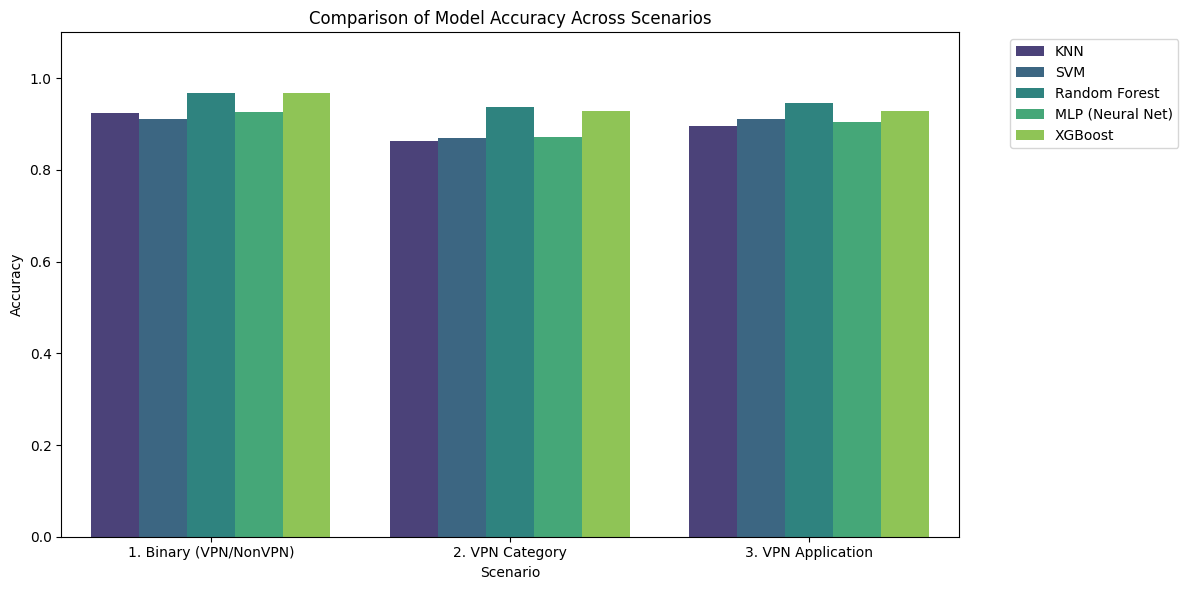

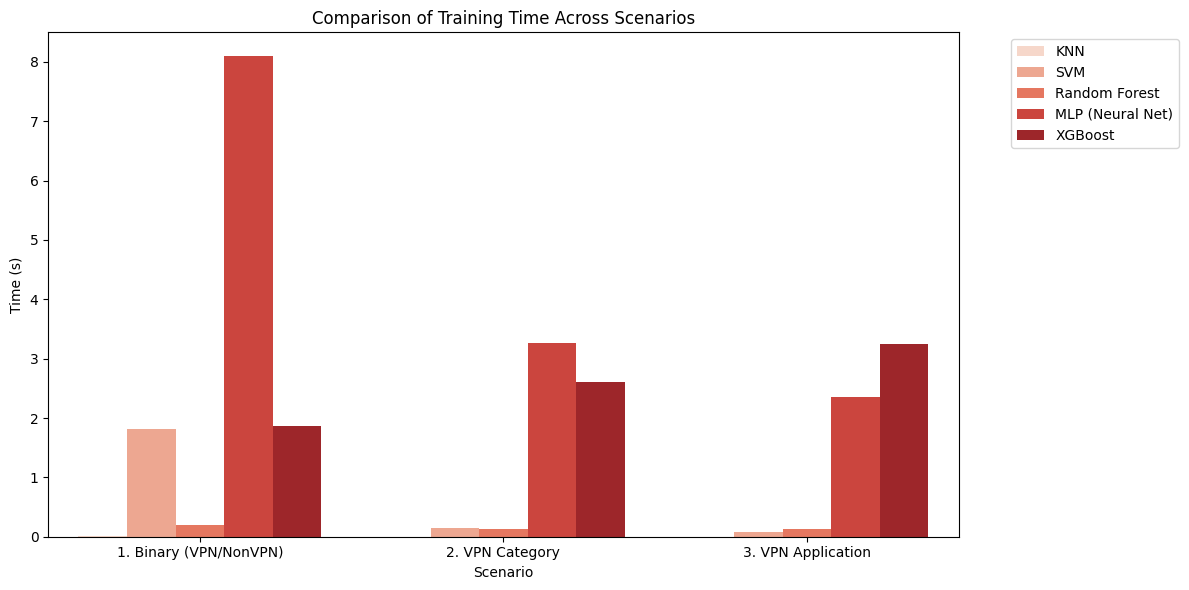

In [ ]:
# ==============================================================================
# EKSPERIMEN 2: PERBANDINGAN ALGORITMA (CORRECTED & EXTENSIVE)
# ==============================================================================

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import Models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("WARNING: XGBoost not installed. Skipping XGBoost.")

# ---------------------------------------------------------
# 1. KONFIGURASI PATH
# ---------------------------------------------------------
BASE_PATH = "/content/drive/MyDrive/1 Skripsi/skrip16feb"  # Adjust if needed
DATASET_PATH = os.path.join(BASE_PATH, "HFV_dataset.csv")
SPLIT_MAP_PATH = os.path.join(BASE_PATH, "alpha_train_test_split_map.csv")

# Target Apps (Sesuai Bab 4)
TARGET_APPS = ['Skype', 'BitTorrent', 'Hangout', 'Facebook', 'YouTube', 'Email']

# ---------------------------------------------------------
# 2. LOAD & MERGE DATA
# ---------------------------------------------------------
print(f"--- Loading Dataset... ---")
df = pd.read_csv(DATASET_PATH)
split_map = pd.read_csv(SPLIT_MAP_PATH)

# --- FIX 1: Normalize Column Names ---
# Ensure we map 'split_group' correctly regardless of case
split_map_cols = {c: c.lower().strip() for c in split_map.columns}
split_map = split_map.rename(columns=split_map_cols)

# Identify the split column (Based on your diagnostic: 'split_group')
split_col_name = 'split_group'
if 'split_group' not in split_map.columns:
    # Fallback search if name changes again
    for c in split_map.columns:
        if 'split' in c or 'group' in c:
            split_col_name = c
            break

print(f"Detected Split Column: '{split_col_name}'")

# Normalize values to lowercase ('train', 'test')
split_map[split_col_name] = split_map[split_col_name].astype(str).str.lower()
split_map['filename'] = split_map['filename'].astype(str)

# --- FIX 2: Merge ---
print("Merging dataset with split map...")
df_merged = pd.merge(df, split_map[['filename', split_col_name]], on='filename', how='inner')
print(f"Total Data after merge: {len(df_merged)}")

# Define Features (Full Hybrid Set)
all_cols = set(df_merged.columns)
# Auto-detect feature columns based on prefixes
feature_cols = sorted([c for c in all_cols if
                       c.startswith('alpha_pp_') or
                       c.startswith(('c2s_', 's2c_', 'flow_', 'total_')) or
                       c.startswith('burst_') or c.startswith(('s2c_burst_', 'c2s_burst_'))])

print(f"Total Features Detected: {len(feature_cols)}")

# ---------------------------------------------------------
# 3. EXPERIMENT FUNCTION
# ---------------------------------------------------------
def run_comparison(df_data, target_col, scenario_name):
    print(f"\n{'='*60}")
    print(f" SCENARIO: {scenario_name} (Target: {target_col})")
    print(f"{'='*60}")

    # Filter Train/Test using the map column
    df_train = df_data[df_data[split_col_name] == 'train']
    df_test = df_data[df_data[split_col_name] == 'test']

    print(f"Samples -> Train: {len(df_train)} | Test: {len(df_test)}")

    if len(df_train) == 0 or len(df_test) == 0:
        print("ERROR: No data found for train or test split. Check map values.")
        return []

    # Prepare Data
    X_train = df_train[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y_train = df_train[target_col]
    X_test = df_test[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y_test = df_test[target_col]

    # Encode Labels
    le = LabelEncoder()
    # Fit on combined data to handle all classes
    le.fit(pd.concat([y_train, y_test]).astype(str))
    y_train_enc = le.transform(y_train.astype(str))
    y_test_enc = le.transform(y_test.astype(str))

    # Scale Data (Required for KNN, SVM, MLP)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    # Models to Test
    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='rbf', random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
    }
    if HAS_XGB:
        models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)

    results = []

    for name, model in models.items():
        print(f" > Training {name}...")
        start_t = time.time()
        try:
            model.fit(X_train_sc, y_train_enc)
            train_time = time.time() - start_t

            y_pred = model.predict(X_test_sc)
            acc = accuracy_score(y_test_enc, y_pred)
            f1 = f1_score(y_test_enc, y_pred, average='macro')

            results.append({
                "Scenario": scenario_name,
                "Model": name,
                "Accuracy": acc,
                "F1-Score": f1,
                "Time (s)": train_time
            })
            print(f"   [OK] Acc: {acc:.4f} | Time: {train_time:.2f}s")
        except Exception as e:
            print(f"   [FAIL] {e}")

    return results

# ---------------------------------------------------------
# 4. EXECUTE SCENARIOS
# ---------------------------------------------------------
all_results = []

# --- SCENARIO 1: BINARY (VPN vs NonVPN) ---
# Check if column exists based on diagnostic
if 'binary_type' in df_merged.columns:
    res = run_comparison(df_merged, 'binary_type', '1. Binary (VPN/NonVPN)')
    all_results.extend(res)

# --- PREPARE VPN DATA ONLY ---
df_vpn = df_merged[df_merged['binary_type'] == 'VPN'].copy()

# --- SCENARIO 2: CATEGORY (VoIP, Chat, etc) ---
if 'category' in df_merged.columns:
    res = run_comparison(df_vpn, 'category', '2. VPN Category')
    all_results.extend(res)

# --- SCENARIO 3: APPLICATION (Skype, Youtube, etc) ---
# Filter for specific target apps only
df_vpn_apps = df_vpn[df_vpn['application'].isin(TARGET_APPS)].copy()
if 'application' in df_merged.columns and len(df_vpn_apps) > 0:
    res = run_comparison(df_vpn_apps, 'application', '3. VPN Application')
    all_results.extend(res)

# ---------------------------------------------------------
# 5. VISUALIZATION
# ---------------------------------------------------------
if len(all_results) > 0:
    final_df = pd.DataFrame(all_results)

    print("\n=== FINAL RESULTS TABLE ===")
    print(final_df)

    # Save to CSV
    final_df.to_csv("Experiment2_AlgorithmComparison_Results.csv", index=False)

    # PLOT 1: ACCURACY
    plt.figure(figsize=(12, 6))
    sns.barplot(data=final_df, x='Scenario', y='Accuracy', hue='Model', palette='viridis')
    plt.title("Comparison of Model Accuracy Across Scenarios")
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # PLOT 2: TIME
    plt.figure(figsize=(12, 6))
    sns.barplot(data=final_df, x='Scenario', y='Time (s)', hue='Model', palette='Reds')
    plt.title("Comparison of Training Time Across Scenarios")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No results generated. Check your data filtering.")

--- Loading Dataset... ---
Merging dataset dengan split map...
Total Data (VPN Only): 2411

Melatih Random Forest untuk mengekstrak Feature Importance...

Hasil disimpan ke 'hasil_feature_importance.csv'

=== TOP 10 FITUR TERPENTING ===
         Feature  Importance             Type
88   alpha_pp_63    0.047381  Alpha (Payload)
36   alpha_pp_16    0.028794  Alpha (Payload)
37   alpha_pp_17    0.028032  Alpha (Payload)
97   alpha_pp_71    0.026950  Alpha (Payload)
55   alpha_pp_33    0.024372  Alpha (Payload)
99   alpha_pp_73    0.022899  Alpha (Payload)
2    alpha_pp_10    0.021623  Alpha (Payload)
127  alpha_pp_99    0.019494  Alpha (Payload)
110  alpha_pp_83    0.018898  Alpha (Payload)
111  alpha_pp_84    0.018013  Alpha (Payload)


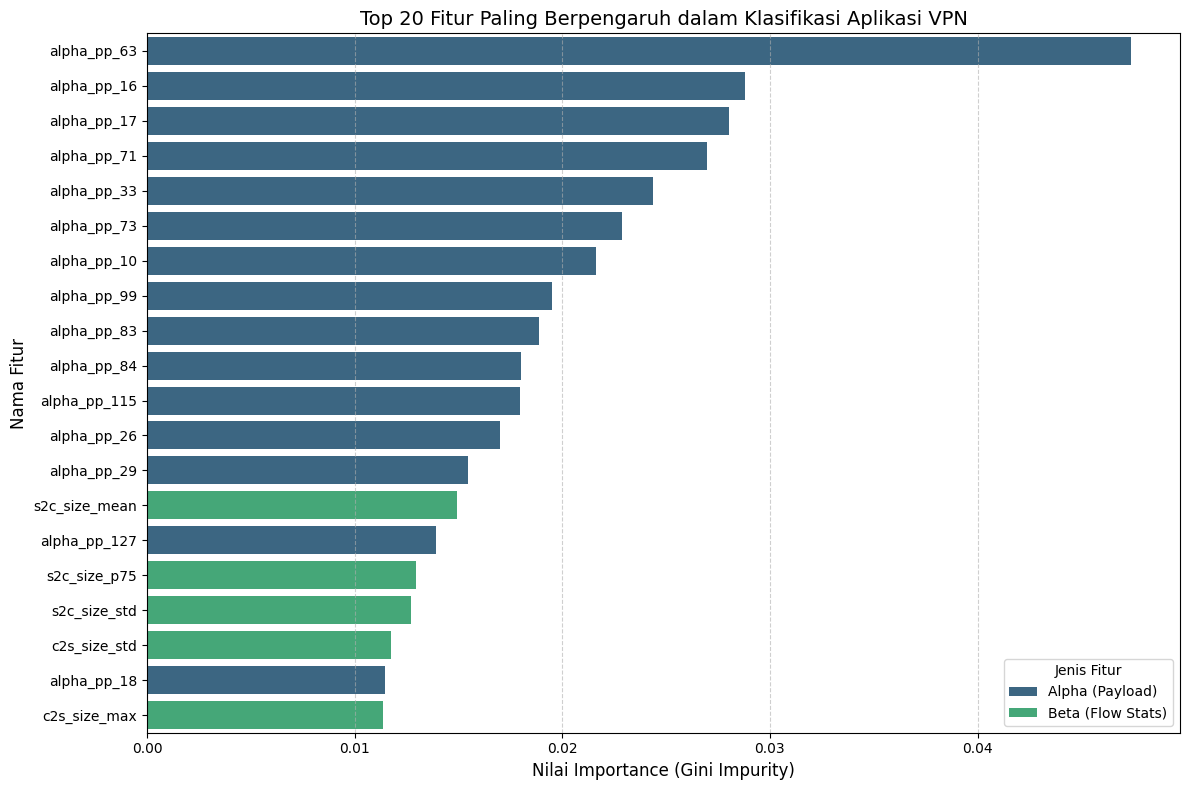

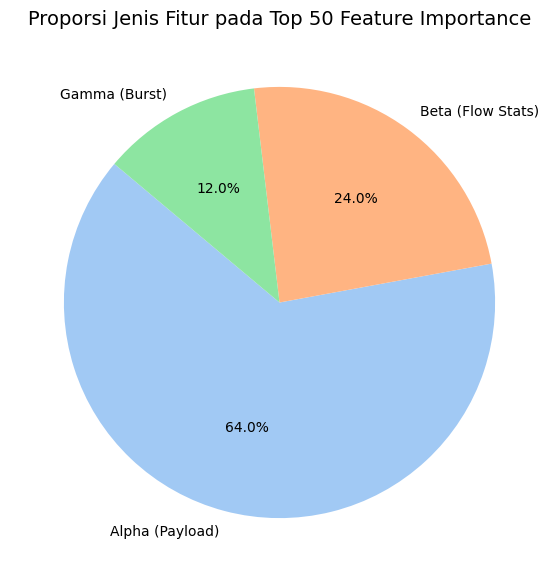

/tmp/ipython-input-3518134919.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Type', data=total_importance.sort_values('Importance', ascending=False), palette='magma')


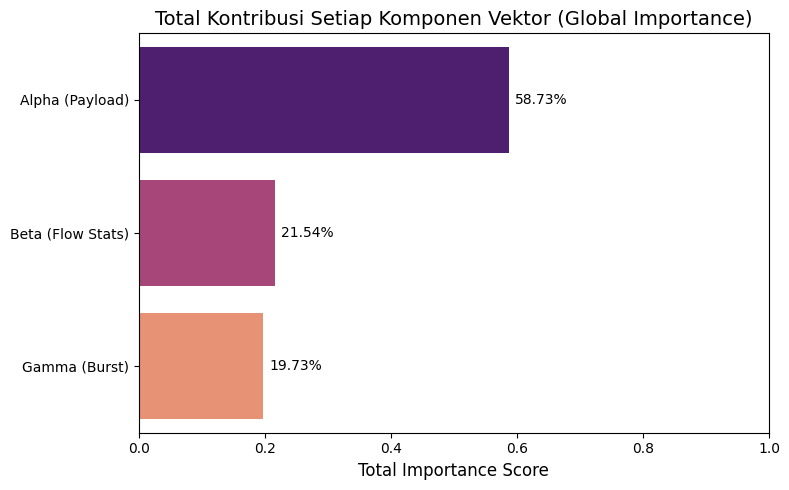

In [ ]:
# ==============================================================================
# EKSPERIMEN 3: FEATURE IMPORTANCE ANALYSIS (HFV)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------
# 1. KONFIGURASI & LOAD DATA
# ---------------------------------------------------------
BASE_PATH = "/content/drive/MyDrive/1 Skripsi/skrip16feb"  # Sesuaikan path Anda
DATASET_PATH = os.path.join(BASE_PATH, "HFV_dataset.csv")
SPLIT_MAP_PATH = os.path.join(BASE_PATH, "alpha_train_test_split_map.csv")

# Target Apps (Fokus pada Skenario Aplikasi VPN yang paling kompleks)
TARGET_APPS = ['Skype', 'BitTorrent', 'Hangout', 'Facebook', 'YouTube', 'Email']

print(f"--- Loading Dataset... ---")
df = pd.read_csv(DATASET_PATH)
split_map = pd.read_csv(SPLIT_MAP_PATH)

# Normalisasi Nama Kolom Split Map
split_map_cols = {c: c.lower().strip() for c in split_map.columns}
split_map = split_map.rename(columns=split_map_cols)

# Deteksi kolom split (biasanya 'split_group')
split_col_name = 'split_group' if 'split_group' in split_map.columns else 'split'
split_map[split_col_name] = split_map[split_col_name].astype(str).str.lower()
split_map['filename'] = split_map['filename'].astype(str)

# Merge Dataset
print("Merging dataset dengan split map...")
df_merged = pd.merge(df, split_map[['filename', split_col_name]], on='filename', how='inner')

# Filter Data: Hanya VPN dan Aplikasi Target
df_vpn = df_merged[df_merged['binary_type'] == 'VPN'].copy()
df_final = df_vpn[df_vpn['application'].isin(TARGET_APPS)].copy()

print(f"Total Data (VPN Only): {len(df_final)}")

# ---------------------------------------------------------
# 2. PERSIAPAN FITUR & TRAINING
# ---------------------------------------------------------
# Definisi Fitur (Hybrid)
all_cols = set(df_final.columns)
feature_cols = sorted([c for c in all_cols if
                       c.startswith('alpha_pp_') or
                       c.startswith(('c2s_', 's2c_', 'flow_', 'total_')) or
                       c.startswith('burst_') or c.startswith(('s2c_burst_', 'c2s_burst_'))])

# Pisahkan X dan y (Gunakan TRAIN set saja untuk analisis importance)
df_train = df_final[df_final[split_col_name] == 'train']
X_train = df_train[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
y_train = df_train['application']

# Encode Label
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# Train Random Forest (Juara Eksperimen 2)
print("\nMelatih Random Forest untuk mengekstrak Feature Importance...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_enc)

# ---------------------------------------------------------
# 3. EKSTRAKSI & KATEGORISASI IMPORTANCE
# ---------------------------------------------------------
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] # Urutkan dari terbesar

# Buat DataFrame Hasil
fi_data = []
for f, imp in zip(np.array(feature_cols), importances):
    # Tentukan Kategori Fitur
    if f.startswith('alpha_pp_'):
        f_type = 'Alpha (Payload)'
    elif 'burst' in f:
        f_type = 'Gamma (Burst)'
    else:
        f_type = 'Beta (Flow Stats)' # Flow, Packet Size, IAT

    fi_data.append({'Feature': f, 'Importance': imp, 'Type': f_type})

fi_df = pd.DataFrame(fi_data).sort_values(by='Importance', ascending=False)

# Simpan ke CSV
fi_df.to_csv('hasil_feature_importance.csv', index=False)
print("\nHasil disimpan ke 'hasil_feature_importance.csv'")

# Tampilkan Top 10
print("\n=== TOP 10 FITUR TERPENTING ===")
print(fi_df.head(10))

# ---------------------------------------------------------
# 4. VISUALISASI (UNTUK BAB 4)
# ---------------------------------------------------------

# A. Bar Chart Top 20 Features
plt.figure(figsize=(12, 8))
top_20 = fi_df.head(20)
sns.barplot(x='Importance', y='Feature', hue='Type', data=top_20, dodge=False, palette='viridis')
plt.title('Top 20 Fitur Paling Berpengaruh dalam Klasifikasi Aplikasi VPN', fontsize=14)
plt.xlabel('Nilai Importance (Gini Impurity)', fontsize=12)
plt.ylabel('Nama Fitur', fontsize=12)
plt.legend(title='Jenis Fitur', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# B. Pie Chart: Kontribusi Komponen di Top 50
# Kita ingin melihat seberapa "Hybrid" model kita sebenarnya
top_50 = fi_df.head(50)
type_counts = top_50['Type'].value_counts()

plt.figure(figsize=(7, 7))
colors = sns.color_palette('pastel')[0:3]
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proporsi Jenis Fitur pada Top 50 Feature Importance', fontsize=14)
plt.show()

# C. Agregat Importance per Tipe (Total Kontribusi)
# Menjumlahkan total importance seluruh fitur berdasarkan tipenya
total_importance = fi_df.groupby('Type')['Importance'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Type', data=total_importance.sort_values('Importance', ascending=False), palette='magma')
plt.title('Total Kontribusi Setiap Komponen Vektor (Global Importance)', fontsize=14)
plt.xlabel('Total Importance Score', fontsize=12)
plt.ylabel('')
plt.xlim(0, 1.0) # Total pasti 1.0
for index, row in total_importance.sort_values('Importance', ascending=False).iterrows():
    plt.text(row.Importance + 0.01, index, f'{row.Importance:.2%}', va='center', color='black')
plt.tight_layout()
plt.show()

--- Loading Dataset... ---
Merging dataset dengan split map...
Total Data (VPN Only): 2751
Kategori yang dianalisis: ['File Transfer', 'Chat', 'VoIP', 'Streaming', 'P2P', 'Email']

Melatih Random Forest untuk Target: category...

Hasil disimpan ke 'hasil_feature_importance_CATEGORY.csv'


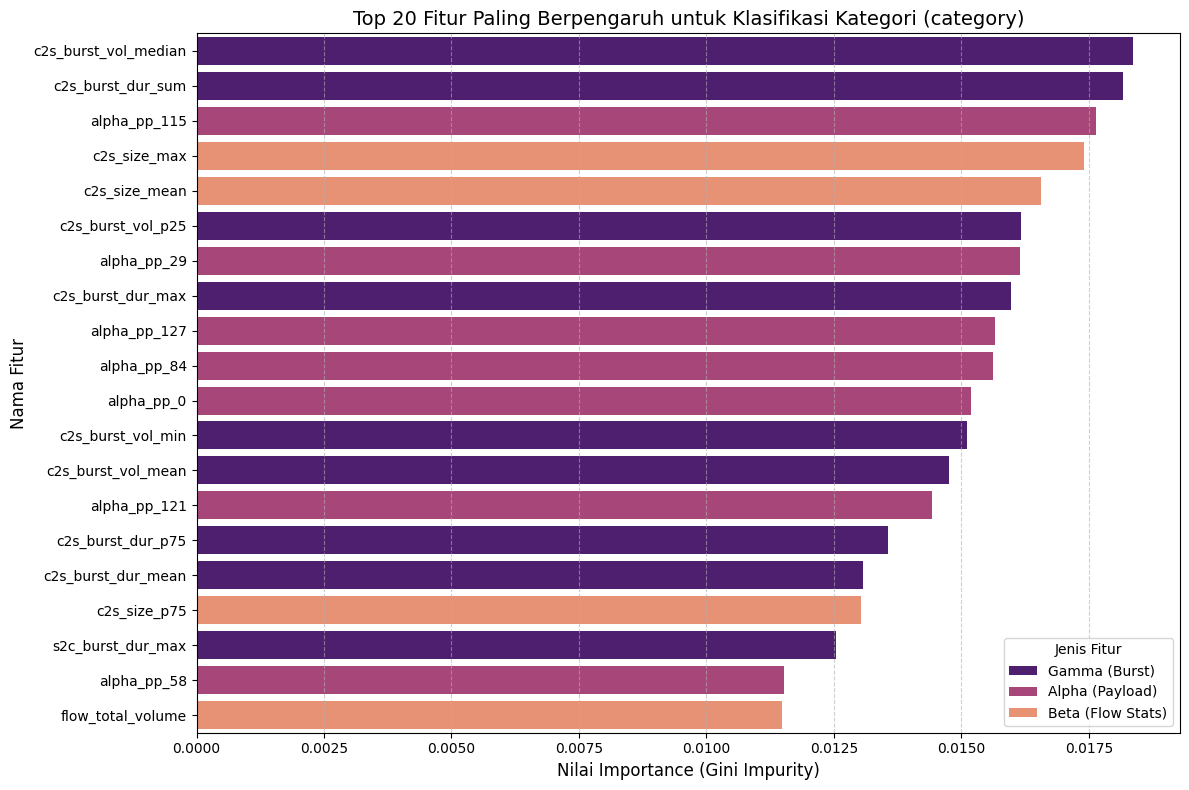

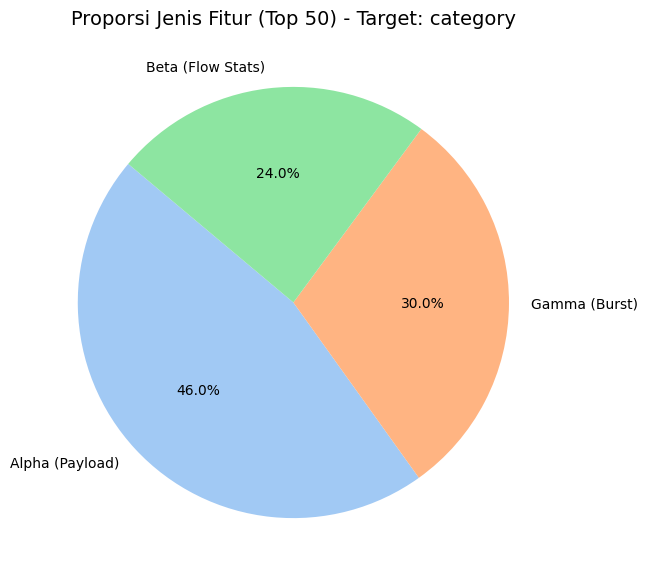

/tmp/ipython-input-3942815509.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Type', data=total_importance.sort_values('Importance', ascending=False), palette='viridis')


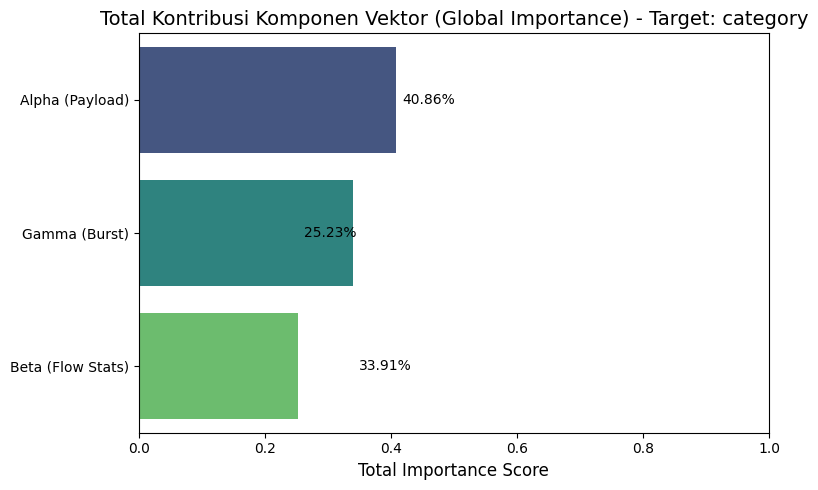

In [ ]:
# ==============================================================================
# EKSPERIMEN 3b: FEATURE IMPORTANCE ANALYSIS (TARGET: CATEGORY)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------
# 1. KONFIGURASI & LOAD DATA
# ---------------------------------------------------------
BASE_PATH = "/content/drive/MyDrive/1 Skripsi/skrip16feb"  # Sesuaikan path Anda
DATASET_PATH = os.path.join(BASE_PATH, "HFV_dataset.csv")
SPLIT_MAP_PATH = os.path.join(BASE_PATH, "alpha_train_test_split_map.csv")

# Target kita sekarang adalah KATEGORI
TARGET_COL = 'category'

print(f"--- Loading Dataset... ---")
df = pd.read_csv(DATASET_PATH)
split_map = pd.read_csv(SPLIT_MAP_PATH)

# Normalisasi Nama Kolom Split Map
split_map_cols = {c: c.lower().strip() for c in split_map.columns}
split_map = split_map.rename(columns=split_map_cols)

# Deteksi kolom split
split_col_name = 'split_group' if 'split_group' in split_map.columns else 'split'
split_map[split_col_name] = split_map[split_col_name].astype(str).str.lower()
split_map['filename'] = split_map['filename'].astype(str)

# Merge Dataset
print("Merging dataset dengan split map...")
df_merged = pd.merge(df, split_map[['filename', split_col_name]], on='filename', how='inner')

# Filter Data: AMBIL SEMUA TRAFIK VPN
# Kita tidak memfilter aplikasi tertentu karena tujuannya melihat kategori secara umum
df_vpn = df_merged[df_merged['binary_type'] == 'VPN'].copy()

# Cek apakah kolom kategori ada
if TARGET_COL not in df_vpn.columns:
    raise ValueError(f"Kolom '{TARGET_COL}' tidak ditemukan dalam dataset!")

# Hapus kategori yang jumlah sampelnya terlalu sedikit (opsional, untuk kebersihan grafik)
# Misalnya kita hanya ambil kategori yang punya minimal 10 sampel
cat_counts = df_vpn[TARGET_COL].value_counts()
valid_cats = cat_counts[cat_counts > 10].index
df_final = df_vpn[df_vpn[TARGET_COL].isin(valid_cats)].copy()

print(f"Total Data (VPN Only): {len(df_final)}")
print(f"Kategori yang dianalisis: {list(df_final[TARGET_COL].unique())}")

# ---------------------------------------------------------
# 2. PERSIAPAN FITUR & TRAINING
# ---------------------------------------------------------
# Definisi Fitur (Hybrid)
all_cols = set(df_final.columns)
feature_cols = sorted([c for c in all_cols if
                       c.startswith('alpha_pp_') or
                       c.startswith(('c2s_', 's2c_', 'flow_', 'total_')) or
                       c.startswith('burst_') or c.startswith(('s2c_burst_', 'c2s_burst_'))])

# Pisahkan X dan y (Gunakan TRAIN set saja)
df_train = df_final[df_final[split_col_name] == 'train']
X_train = df_train[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
y_train = df_train[TARGET_COL]

# Encode Label
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# Train Random Forest
print(f"\nMelatih Random Forest untuk Target: {TARGET_COL}...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_enc)

# ---------------------------------------------------------
# 3. EKSTRAKSI & KATEGORISASI IMPORTANCE
# ---------------------------------------------------------
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

fi_data = []
for f, imp in zip(np.array(feature_cols), importances):
    if f.startswith('alpha_pp_'):
        f_type = 'Alpha (Payload)'
    elif 'burst' in f:
        f_type = 'Gamma (Burst)'
    else:
        f_type = 'Beta (Flow Stats)'

    fi_data.append({'Feature': f, 'Importance': imp, 'Type': f_type})

fi_df = pd.DataFrame(fi_data).sort_values(by='Importance', ascending=False)

# Simpan ke CSV
fi_df.to_csv('hasil_feature_importance_CATEGORY.csv', index=False)
print("\nHasil disimpan ke 'hasil_feature_importance_CATEGORY.csv'")

# ---------------------------------------------------------
# 4. VISUALISASI
# ---------------------------------------------------------

# A. Bar Chart Top 20 Features
plt.figure(figsize=(12, 8))
top_20 = fi_df.head(20)
sns.barplot(x='Importance', y='Feature', hue='Type', data=top_20, dodge=False, palette='magma')
plt.title(f'Top 20 Fitur Paling Berpengaruh untuk Klasifikasi Kategori ({TARGET_COL})', fontsize=14)
plt.xlabel('Nilai Importance (Gini Impurity)', fontsize=12)
plt.ylabel('Nama Fitur', fontsize=12)
plt.legend(title='Jenis Fitur', loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# B. Pie Chart: Kontribusi Komponen di Top 50
top_50 = fi_df.head(50)
type_counts = top_50['Type'].value_counts()

plt.figure(figsize=(7, 7))
colors = sns.color_palette('pastel')[0:3]
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title(f'Proporsi Jenis Fitur (Top 50) - Target: {TARGET_COL}', fontsize=14)
plt.show()

# C. Agregat Importance per Tipe
total_importance = fi_df.groupby('Type')['Importance'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Type', data=total_importance.sort_values('Importance', ascending=False), palette='viridis')
plt.title(f'Total Kontribusi Komponen Vektor (Global Importance) - Target: {TARGET_COL}', fontsize=14)
plt.xlabel('Total Importance Score', fontsize=12)
plt.ylabel('')
plt.xlim(0, 1.0)
for index, row in total_importance.sort_values('Importance', ascending=False).iterrows():
    plt.text(row.Importance + 0.01, index, f'{row.Importance:.2%}', va='center', color='black')
plt.tight_layout()
plt.show()